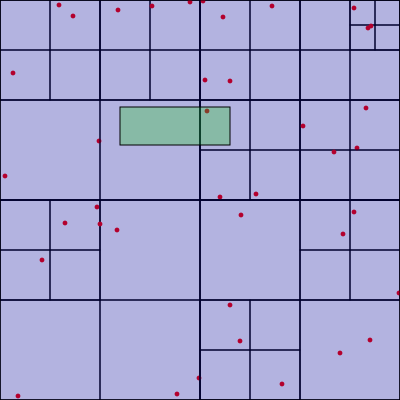

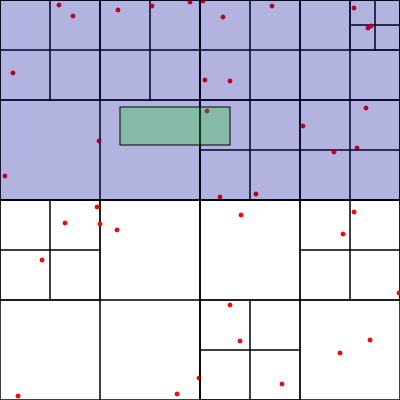

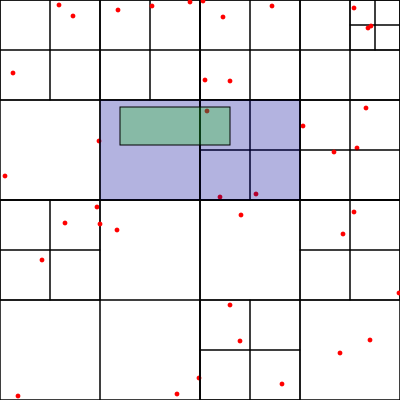

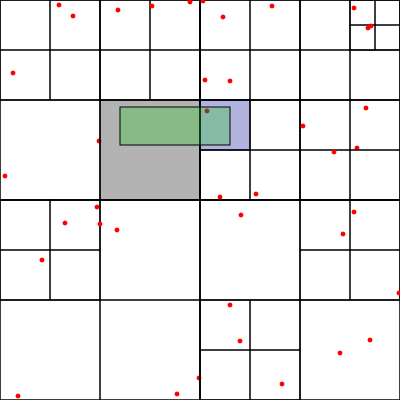

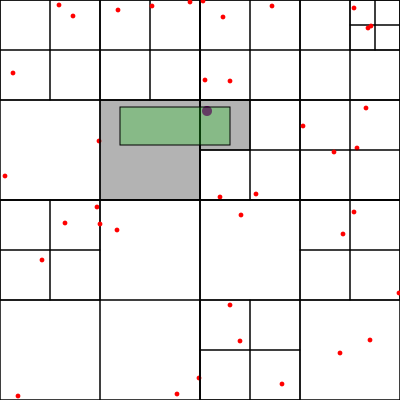

In [9]:
from pprint import *
from random import *
from dataclasses import *
from cairosvg import svg2png  # pip install cairosvg

from IPython.display import Image
from IPython.display import display

from utils import *


@dataclass
class Point:
    x: float
    y: float

    def distance(p1, p2):
        (p1.x - p2.x)**2 + (p1.y - p2.y)**2


@dataclass
class Geometry:
    x: float
    y: float
    w: float
    h: float

    def intersects(g1, g2):
        ix = insersects((g1.x, g1.x + g1.w), (g2.x, g2.x + g2.w))
        iy = insersects((g1.y, g1.y + g1.h), (g2.y, g2.y + g2.h))

        return (ix and iy)

    def contains(g, p):
        return (
            (p.x >= g.x and p.x <= (g.x + g.w)) and
            (p.y >= g.y and p.y <= (g.y + g.h)))


@dataclass
class Entry:
    id: int
    location: Point


@dataclass
class QuadNode:
    entries: list
    nodes: list
    geometry: Geometry
    level: int

    def whichQuadrant(qn, e) -> int:
        xMid = qn.geometry.x + qn.geometry.w/2
        yMid = qn.geometry.y + qn.geometry.h/2

        if e.location.x < xMid:
            if e.location.y < yMid:
                return 0
            else:
                return 1
        else:
            if e.location.y < yMid:
                return 2
            else:
                return 3

    def is_final(qn):
        return len(qn.nodes) == 0


class QuadSpace:
    root: QuadNode
    limit: float
    maxDepth: int

    def __init__(self, geo: Geometry, limit: int, mdepth: int):
        self.limit = limit
        self.maxDepth = mdepth
        self.root = QuadNode(geometry=geo, nodes=[], entries=[], level=0)

    def split(qs, qn: QuadNode):
        x = qn.geometry.x
        y = qn.geometry.y
        w = qn.geometry.w/2
        h = qn.geometry.h/2
        l = qn.level + 1

        qn.nodes = [
            QuadNode([], [], Geometry(x=x, y=y, w=w, h=h), l),
            QuadNode([], [], Geometry(x=x, y=y+h, w=w, h=h), l),
            QuadNode([], [], Geometry(x=x+w, y=y, w=w, h=h), l),
            QuadNode([], [], Geometry(x=x+w, y=y+h, w=w, h=h), l),
        ]

        for e in qn.entries:
            index = qn.whichQuadrant(e)
            qs._insert(qn.nodes[index], e)

        qn.entries = []

    def insert(self, e: Entry):
        self._insert(self.root, e)

    def _insert(qs, qn: QuadNode, e: Entry):
        if not qn.is_final():
            index = qn.whichQuadrant(e)
            qs._insert(qn.nodes[index], e)

        else:
            qn.entries.append(e)

            if (qn.level <= qs.maxDepth) and (len(qn.entries) > qs.limit):
                qs.split(qn)

    def find(qs, query: Geometry, level=-1):
        result = []
        qs._find(qs.root, query, result, level)
        return result

    def _find(qs, qn: QuadNode, query: Geometry, acc, level):
        if qn.level == level:
            acc.append(qn)

        for n in qn.nodes:
            if n.geometry.intersects(query):
                qs._find(n, query, acc, level)

        for e in qn.entries:
            if level == -1:
                if query.contains(e.location):
                    acc.append(e)

    def image(qs, extra=""):
        return svg2png(bytestring=qs.svgrepr(extra))

    def svgrepr(qs, extra):
        HEADER = f"""<?xml version="1.0" standalone="no"?>
          <svg width="{qs.root.geometry.w}" height="{qs.root.geometry.h}" 
          version="1.1" xmlns="http://www.w3.org/2000/svg">
          <rect x="0" y="0" width="{qs.root.geometry.w}" height="{qs.root.geometry.h}" fill="white"/>
        """

        svg_elements = []
        qs._svgrepr(qs.root, svg_elements)

        return "".join([HEADER, *svg_elements, extra, "</svg>"])

    def _svgrepr(qs, qn, acc):
        for n in qn.nodes:
            acc.append(svg_rect(n.geometry))
            qs._svgrepr(n, acc)

        for e in qn.entries:
            acc.append(svg_cirle(e.location.x, e.location.y))


def take_snapshot(qs, extra=""):
    save_file_binary("temp.png", qs.image(extra))
    return Image(filename="temp.png")


def gen_search_process(qs, query):
    result = []
    final_qnodes = []

    query_rect = svg_rect(query, "rgba(30, 200, 30, 0.3)")

    for n in range(0, 10):
        nodes = qs.find(query, n)

        ss1 = "".join([svg_rect(n.geometry, "rgba(0,0,0, 0.3)")
                      for n in final_qnodes])

        end = len(nodes) == 0
        if end:
            points = qs.find(query, -1)
            ss2 = "".join(
                [svg_cirle(p.location.x, p.location.y, 5, "purple") for p in points])
        else:
            ss2 = "".join([svg_rect(n.geometry, "rgba(0,0,150,0.3)")
                          for n in nodes])

        result.append(take_snapshot(qs, ss1 + ss2 + query_rect))

        if end:
            break

        for n in nodes:
            if n.is_final():
                final_qnodes.append(n)

    return result


def gen_add_process(qs, entries):
    result = []

    for e in entries:
        qs.insert(e)
        result.append(take_snapshot(qs, svg_cirle(
            e.location.x, e.location.y, 4, "purple")))

    return result


def gen_random_entries(n):
    result = []

    for i in range(n):
        x, y = randrange(0, W),  randrange(0, H)
        e = Entry(i, Point(x, y))
        result.append(e)

    return result


if __name__ == "__main__":
    W = 400
    H = 400

    qs = QuadSpace(Geometry(0, 0, W, H), 2, 6)

    query = Geometry(
        randrange(0, int(W*2/3)), randrange(0, int(H*2/3)),
        randrange(20, int(W/3)), randrange(20, int(H/3))
    )

    # display(*gen_add_process(qs, gen_random_entries(40)))
    gen_add_process(qs, gen_random_entries(40))
    display(*gen_search_process(qs, query))


# NOTE: deletion is not optimal, and should be avoided
